# 🧵 Fashion Object Detection with YOLOv8

Welcome! This notebook walks through building a fashion object detection model using **YOLOv8** — one of the fastest and most accurate object detection models out there. The goal? Spot and label clothing items (like tops, pants, dresses, etc.) in images.

---

### 🔍 What’s Inside:
- Load and prep a dataset of fashion items (in YOLO format)
- Train a YOLOv8 model on that data
- Evaluate how well the model performs
- Run predictions and visualize the results (with bounding boxes!)

---

### 🧰 What You’ll Need:
- A dataset in YOLO format (`data.yaml`, `train/`, `valid/`)
- The `ultralytics` library (for YOLOv8)
- A little Python, a little patience

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

# Initialising Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
data_path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/'

images_path = os.path.join(data_path,"JPEGImages/")
annotations_path = os.path.join(data_path, "Annotations_txt/")

In [4]:
model_path = "/kaggle/input/yolov8_default/other/2/2/yolov8m.pt"
model = YOLO(model_path)

### 📄 YOLO Annotation Sample Description

The file `100034.txt` contains annotations in **YOLO format** used for object detection tasks. Each line in the file corresponds to a single object in the image and follows the structure:

```
<class_id> <x_center> <y_center> <width> <height>
```

All coordinate values are **normalized** (i.e., between 0 and 1) relative to the image dimensions.

In [5]:
# print sample annotations

annotation_sample = "/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations_txt/100034.txt"

with open(annotation_sample, 'r') as a_s:
    print(a_s.read())

3 0.568750 0.257500 0.327500 0.175000
8 0.706250 0.480833 0.212500 0.188333
9 0.557500 0.867500 0.335000 0.235000
6 0.531250 0.511667 0.422500 0.423333


#### 📝 Interpretation of above:
- `class_id`: The object category (e.g., 3, 8, 9, 6).
- `x_center`, `y_center`: The center coordinates of the bounding box, normalized.
- `width`, `height`: The width and height of the bounding box, normalized.

### Description and Explanation:

### **1. `convert()` Function:**

**Purpose:**  
This function is responsible for converting YOLO-style normalized bounding box coordinates into pixel coordinates that are compatible with the actual image dimensions.

**Input Parameters:**  
- `size`: A tuple containing the image's width and height (i.e., `(image_width, image_height)`).
- `x, y`: The normalized x and y coordinates of the center of the bounding box (between 0 and 1).
- `w, h`: The normalized width and height of the bounding box (between 0 and 1).

**Process:**
- It first calculates the width and height of the image in pixels from the provided `size`.
- Then, it scales the normalized coordinates (`x`, `y`, `w`, `h`) to pixel values based on the image dimensions.
- The center coordinates (`x`, `y`) are adjusted to represent the top-left corner and the bottom-right corner of the bounding box by subtracting and adding half of the width (`w/2.0`) and height (`h/2.0`).

**Output:**  
- A list `box` containing the pixel values of the bounding box in the format `[left, right, top, bottom]`.

---

### **2. `plot_annotations()` Function:**

**Purpose:**  
This function reads a YOLO annotation file and overlays the bounding boxes onto a given image, displaying the image with the bounding boxes.

**Input Parameters:**
- `img`: The image on which the bounding boxes will be drawn (using OpenCV).
- `filename`: The name of the YOLO annotation file that contains the bounding box data.

**Process:**
- The function opens the annotation file (`filename`) and reads each line.
- Each line in the file represents an object annotation in the format:
  ```
  class_id x_center y_center width height
  ```
  Where:
  - `class_id`: The integer ID of the object class (not used in this code, but can be used for labeling purposes).
  - `x_center`, `y_center`: The normalized center coordinates of the bounding box.
  - `width`, `height`: The normalized width and height of the bounding box.
  
- The `convert()` function is called to convert the normalized bounding box values to pixel values.
- `cv2.rectangle()` is used to draw a rectangle on the image, which represents the bounding box of the detected object.
- Finally, the image with the bounding boxes is displayed using `matplotlib.pyplot.imshow()`.

In [6]:
import cv2

def convert(size, x, y, w, h):
    box = np.zeros(4)
    dw = 1. / size[0]
    dh = 1. / size[1]

    x = x / dw
    w = w / dw
    y = y / dh
    h = h / dh

    box[0] = x - (w / 2.0)
    box[1] = x + (w / 2.0)
    box[2] = y - (h / 2.0)
    box[3] = y + (h / 2.0)

    return box

def plot_annotations(img, filename):
    with open(annotations_path + filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])

            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x, y, w, h)

            cv2.rectangle(
                img,
                (int(round(bb[0])), int(round(bb[2]))),
                (int(round(bb[1])), int(round(bb[3]))),
                (255, 0, 0),
                2
            )

            plt.axis('off')
            plt.imshow(img)


### Training samples

This code generates a visualization of randomly selected images from a given directory, displaying them along with their corresponding bounding box annotations.

The output is a 2x4 grid of images (with bounding boxes) randomly selected from the dataset, ideal for quickly inspecting object detection annotations.

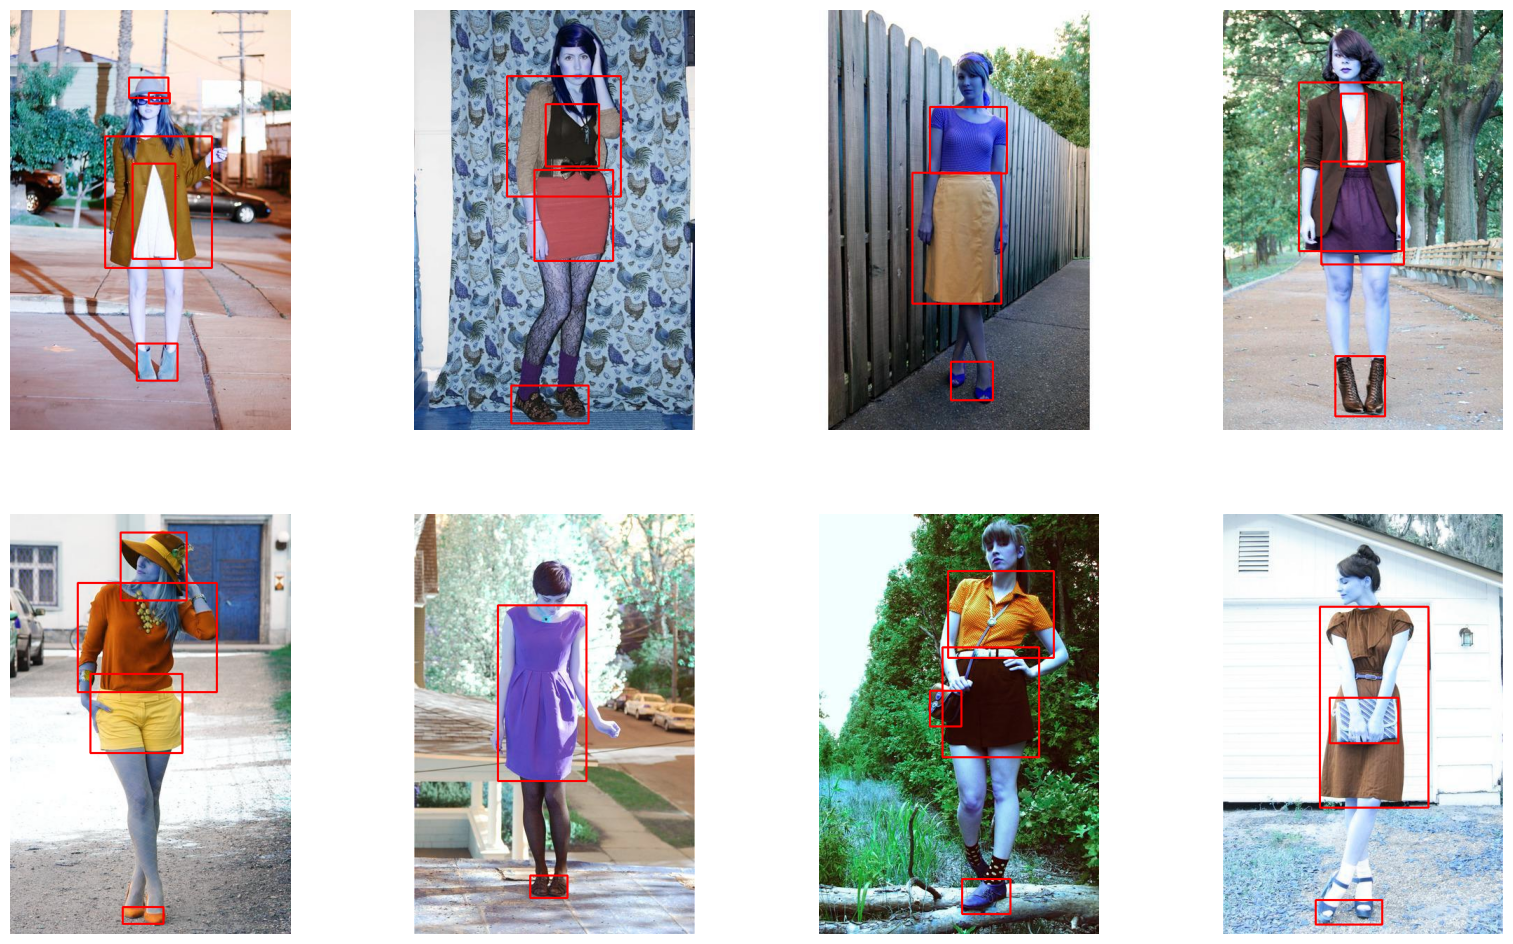

In [7]:
import random

plt.figure(figsize=(20,12))
ls_img = os.listdir(images_path)
c = 1
for i in random.sample(ls_img, 8):
    img = cv2.imread(images_path+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(2,4, c)
    plot_annotations(img, i)
    c+=1

### Prepare Data

This code reads image filenames from `trainval.txt` and `test.txt` files, which are located in the `ImageSets/Main/` directory within the `data_path`. 

The filenames are stripped of any extra whitespace and stored in the `train` and `test` lists, respectively. These lists represent the images used for training/validation and testing in an object detection task.

In [8]:
train = []
with open(os.path.join(data_path + 'ImageSets/Main/trainval.txt'), 'r') as f:
    train = [line.strip() for line in f]

test = []
with open(os.path.join(data_path + 'ImageSets/Main/test.txt'), 'r') as f:
    test = [line.strip() for line in f]


This code organizes and copies image and annotation files into separate directories for training and testing data in an object detection task.

**Key Steps:**

1. **Creating Directories:**
   - It creates the directories `/train/images`, `/train/labels`, `/test/images`, and `/test/labels` if they don’t already exist, to store images and annotations separately for both the train and test datasets.

2. **Reading Image IDs:**
   - The `read_ids()` function reads image IDs from text files (`trainval.txt` and `test.txt`), storing the filenames in the `train` and `test` lists, which are used to fetch corresponding images and annotation files.

3. **Copying Data:**
   - The `copy_data()` function copies images and their corresponding annotation files (with `.jpg` and `.txt` extensions) from the source directories to the destination directories (`train_path` and `test_path`).
   - It checks if both the image and annotation file exist before copying them. If either is missing, it prints a warning and skips that file.

In [10]:
import os
import shutil
import tqdm

train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test/'

for folder in ['train', 'test']:
    folder_path = train_path if folder == "train" else test_path
    os.makedirs(f'{folder_path}/images', exist_ok=True)
    os.makedirs(f'{folder_path}/labels', exist_ok=True)

# Read image ids
def read_ids(file): return [line.strip() for line in open(file)]

# Function to copy files
def copy_data(dataset, src_images_path, src_annotations_path, dst_path):
    for i in tqdm.tqdm(dataset):
        img_src, lbl_src = f'{src_images_path}{i}.jpg', f'{src_annotations_path}{i}.txt'
        img_dst, lbl_dst = f'{dst_path}images/{i}.jpg', f'{dst_path}labels/{i}.txt'

        if os.path.exists(img_src) and os.path.exists(lbl_src):
            shutil.copyfile(img_src, img_dst)
            shutil.copyfile(lbl_src, lbl_dst)
        else:
            print(f"⚠️ Missing file for {i}, skipping...")

# Copy train and test data
print('📦 Copying Train Data...')
copy_data(train, images_path, annotations_path, train_path)
print('📦 Copying Test Data...')
copy_data(test, images_path, annotations_path, test_path)

print("✅ Dataset split complete.")


📦 Copying Train Data...


100%|██████████| 2145/2145 [00:26<00:00, 80.41it/s]


📦 Copying Test Data...


100%|██████████| 537/537 [00:06<00:00, 86.68it/s]

✅ Dataset split complete.


In [11]:
import yaml

# Define the structure as a Python dictionary
data = {
    'train': '/kaggle/working/train',
    'val': '/kaggle/working/test',
    'nc': 10,
    'names': ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
}

# Write to the YAML file
with open("data.yaml", 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

### **Training**

In [12]:
model.train(data='data.yaml', epochs=40)

Ultralytics 8.3.107 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolov8_default/other/2/2/yolov8m.pt, data=data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 156MB/s]
E0000 00:00:1744620220.360045      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744620220.410423      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 304MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 1474.87it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 1266.31it/s]

val: New cache created: /kaggle/working/test/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      8.07G      1.298      1.838      1.425         11        640: 100%|██████████| 135/135 [01:25<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]

                   all        537       2035      0.597      0.631      0.666      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      8.08G       1.26      1.284        1.4          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]

                   all        537       2035      0.636      0.589      0.633      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      8.08G      1.277      1.246      1.407          6        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        537       2035       0.61      0.675      0.663       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      8.08G      1.262      1.188      1.391          9        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.698      0.691      0.717      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      8.08G      1.251      1.139      1.386          6        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        537       2035      0.691      0.681      0.709      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      8.08G      1.232      1.089      1.377          7        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]

                   all        537       2035      0.691      0.746      0.748      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      8.08G      1.205      1.061      1.361          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.674      0.702       0.72      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      8.08G      1.182      1.022      1.352          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        537       2035      0.739      0.726      0.732      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      8.08G      1.162     0.9795      1.331         10        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.729      0.748       0.78      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      8.08G      1.147      0.951      1.326          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.726      0.757      0.778      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      8.08G      1.133     0.9261      1.315          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]

                   all        537       2035      0.711      0.744      0.763       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      8.08G      1.116     0.9139      1.304         10        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.704       0.74      0.772      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      8.08G        1.1     0.8863      1.294          7        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035       0.75      0.731      0.751        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      8.08G      1.082     0.8738      1.286          7        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.699      0.768      0.765      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      8.08G      1.081     0.8391      1.277          8        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.757      0.747      0.787      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      8.08G      1.075     0.8236      1.278          6        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        537       2035      0.713      0.737      0.761       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      8.08G      1.051     0.8129      1.256          8        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.766      0.763      0.798      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      8.08G      1.028     0.7812       1.25          9        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.764      0.745      0.784      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      8.08G      1.016     0.7734      1.246          7        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.732      0.748      0.772      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      8.08G      1.005     0.7547      1.237         10        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.768      0.732       0.78      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      8.08G      1.005     0.7419      1.237         11        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.768      0.744      0.782      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      8.08G     0.9856     0.7198      1.213          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.753      0.774      0.788      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      8.08G     0.9858     0.7173      1.224          5        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.764      0.761      0.777      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      8.08G     0.9617     0.6847      1.201         11        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035       0.76       0.76      0.786      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      8.08G     0.9631     0.6922      1.202          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.758      0.768       0.79       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      8.08G     0.9335     0.6548      1.188          9        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.779      0.758      0.787      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      8.08G     0.9284     0.6468      1.177          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.767      0.756      0.783      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      8.08G     0.9295     0.6446      1.193          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.753      0.774      0.784      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      8.08G     0.8998     0.6154      1.167          8        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.756      0.774      0.787      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      8.08G     0.8976     0.5972       1.16          9        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.763      0.754       0.78      0.541


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      8.08G     0.8401      0.515      1.141          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.777      0.761      0.788      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      8.08G     0.8322        0.5      1.131          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        537       2035      0.784      0.765      0.784      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      8.08G     0.8142     0.4856      1.111          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.771      0.762      0.786      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      8.08G     0.7918     0.4662      1.098          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]

                   all        537       2035      0.791      0.762      0.792      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      8.08G     0.7842     0.4461      1.092          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.768      0.764      0.787       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      8.08G     0.7663     0.4396      1.084          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        537       2035      0.761       0.77      0.786      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      8.08G     0.7542     0.4286      1.073          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]

                   all        537       2035      0.775      0.751      0.782      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      8.08G     0.7448     0.4356      1.063          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035       0.78       0.76      0.785       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      8.08G     0.7278     0.4031      1.055          3        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035       0.78      0.757      0.783      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      8.08G     0.7297     0.4034      1.058          4        640: 100%|██████████| 135/135 [01:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        537       2035      0.789      0.758      0.787      0.545



40 epochs completed in 0.998 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


                   all        537       2035      0.768      0.766      0.787      0.545
              sunglass         82         82      0.556       0.28      0.383      0.144
                   hat         77         77      0.812      0.818       0.83      0.496
                jacket        179        181      0.798      0.764      0.837      0.662
                 shirt        361        366      0.786       0.85      0.836      0.617
                 pants        114        114      0.934      0.912      0.959      0.765
                shorts        107        107       0.78      0.796       0.78      0.518
                 skirt        186        186      0.771      0.852      0.819      0.656
                 dress        128        128      0.686      0.852      0.821       0.67
                   bag        274        274      0.758      0.721      0.771      0.455
                  shoe        520        520      0.798      0.812       0.83      0.468


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 7.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d36d8f67090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

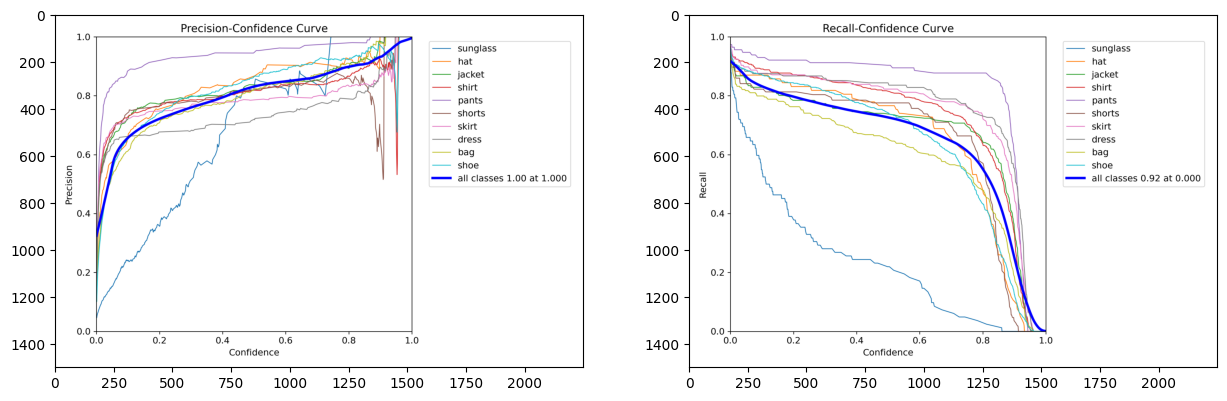

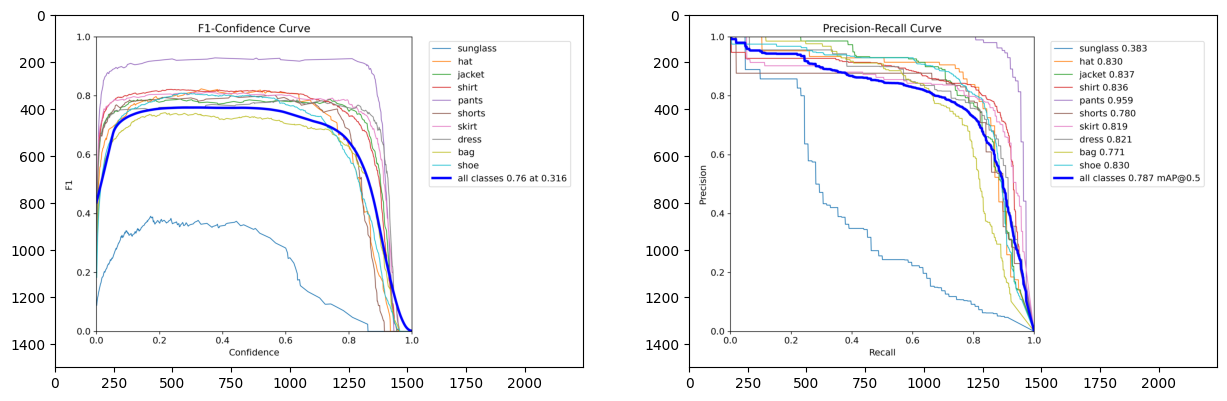

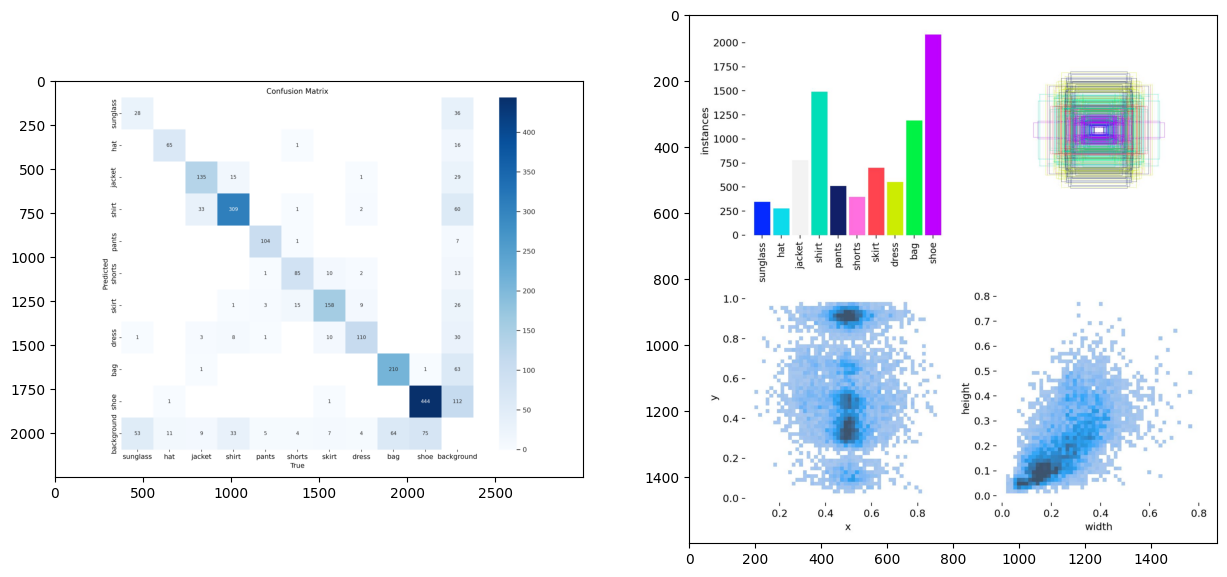

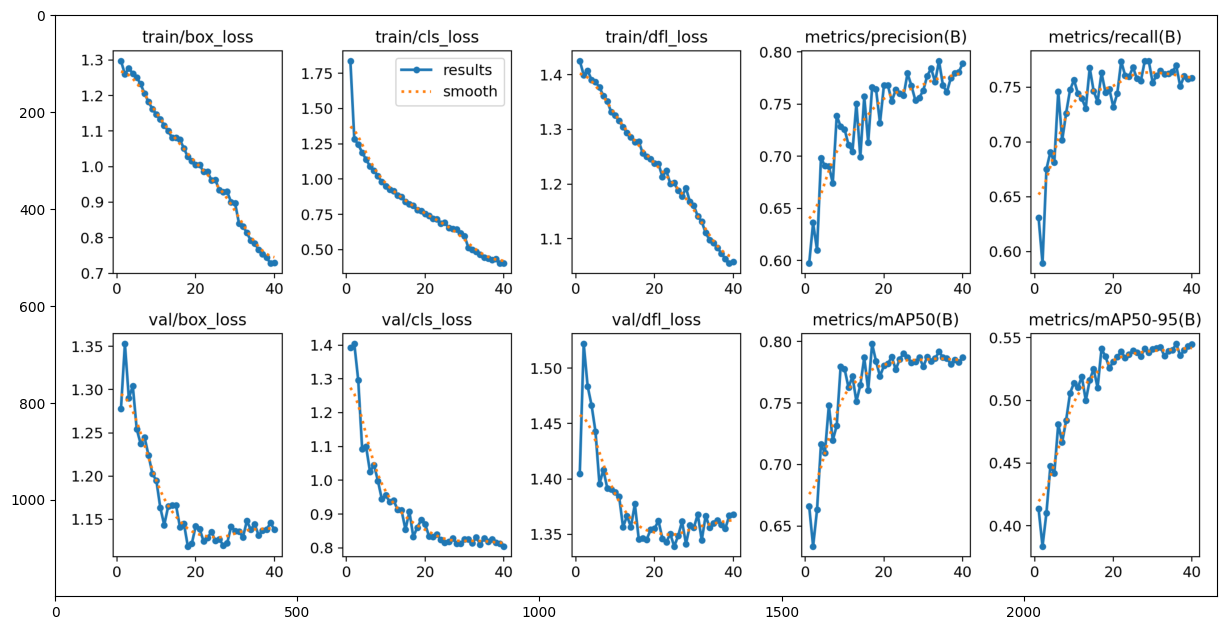

In [13]:
# %matplotlib inline
train_results = 'runs/detect/train/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(train_results+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

### **Results**

| Class     | Images | Instances | Precision (P) | Recall (R) | mAP@0.5 | mAP@0.5:0.95 |
|-----------|--------|-----------|---------------|------------|---------|--------------|
| **all**       | 537    | 2035      | 0.768         | 0.766      | 0.787   | 0.545        |
| sunglass  | 82     | 82        | 0.556         | 0.280      | 0.383   | 0.144        |
| hat       | 77     | 77        | 0.812         | 0.818      | 0.830   | 0.496        |
| jacket    | 179    | 181       | 0.798         | 0.764      | 0.837   | 0.662        |
| shirt     | 361    | 366       | 0.786         | 0.850      | 0.836   | 0.617        |
| pants     | 114    | 114       | 0.934         | 0.912      | 0.959   | 0.765        |
| shorts    | 107    | 107       | 0.780         | 0.796      | 0.780   | 0.518        |
| skirt     | 186    | 186       | 0.771         | 0.852      | 0.819   | 0.656        |
| dress     | 128    | 128       | 0.686         | 0.852      | 0.821   | 0.670        |
| bag       | 274    | 274       | 0.758         | 0.721      | 0.771   | 0.455        |
| shoe      | 520    | 520       | 0.798         | 0.812      | 0.830   | 0.468        |


image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/45325.jpg: 640x448 1 jacket, 1 shirt, 1 skirt, 1 shoe, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /kaggle/working/runs/detect/predict_12

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/103062.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 1 shoe, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /kaggle/working/runs/detect/predict_22

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/96310.jpg: 640x448 1 shirt, 1 skirt, 1 shoe, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /kaggle/working/run

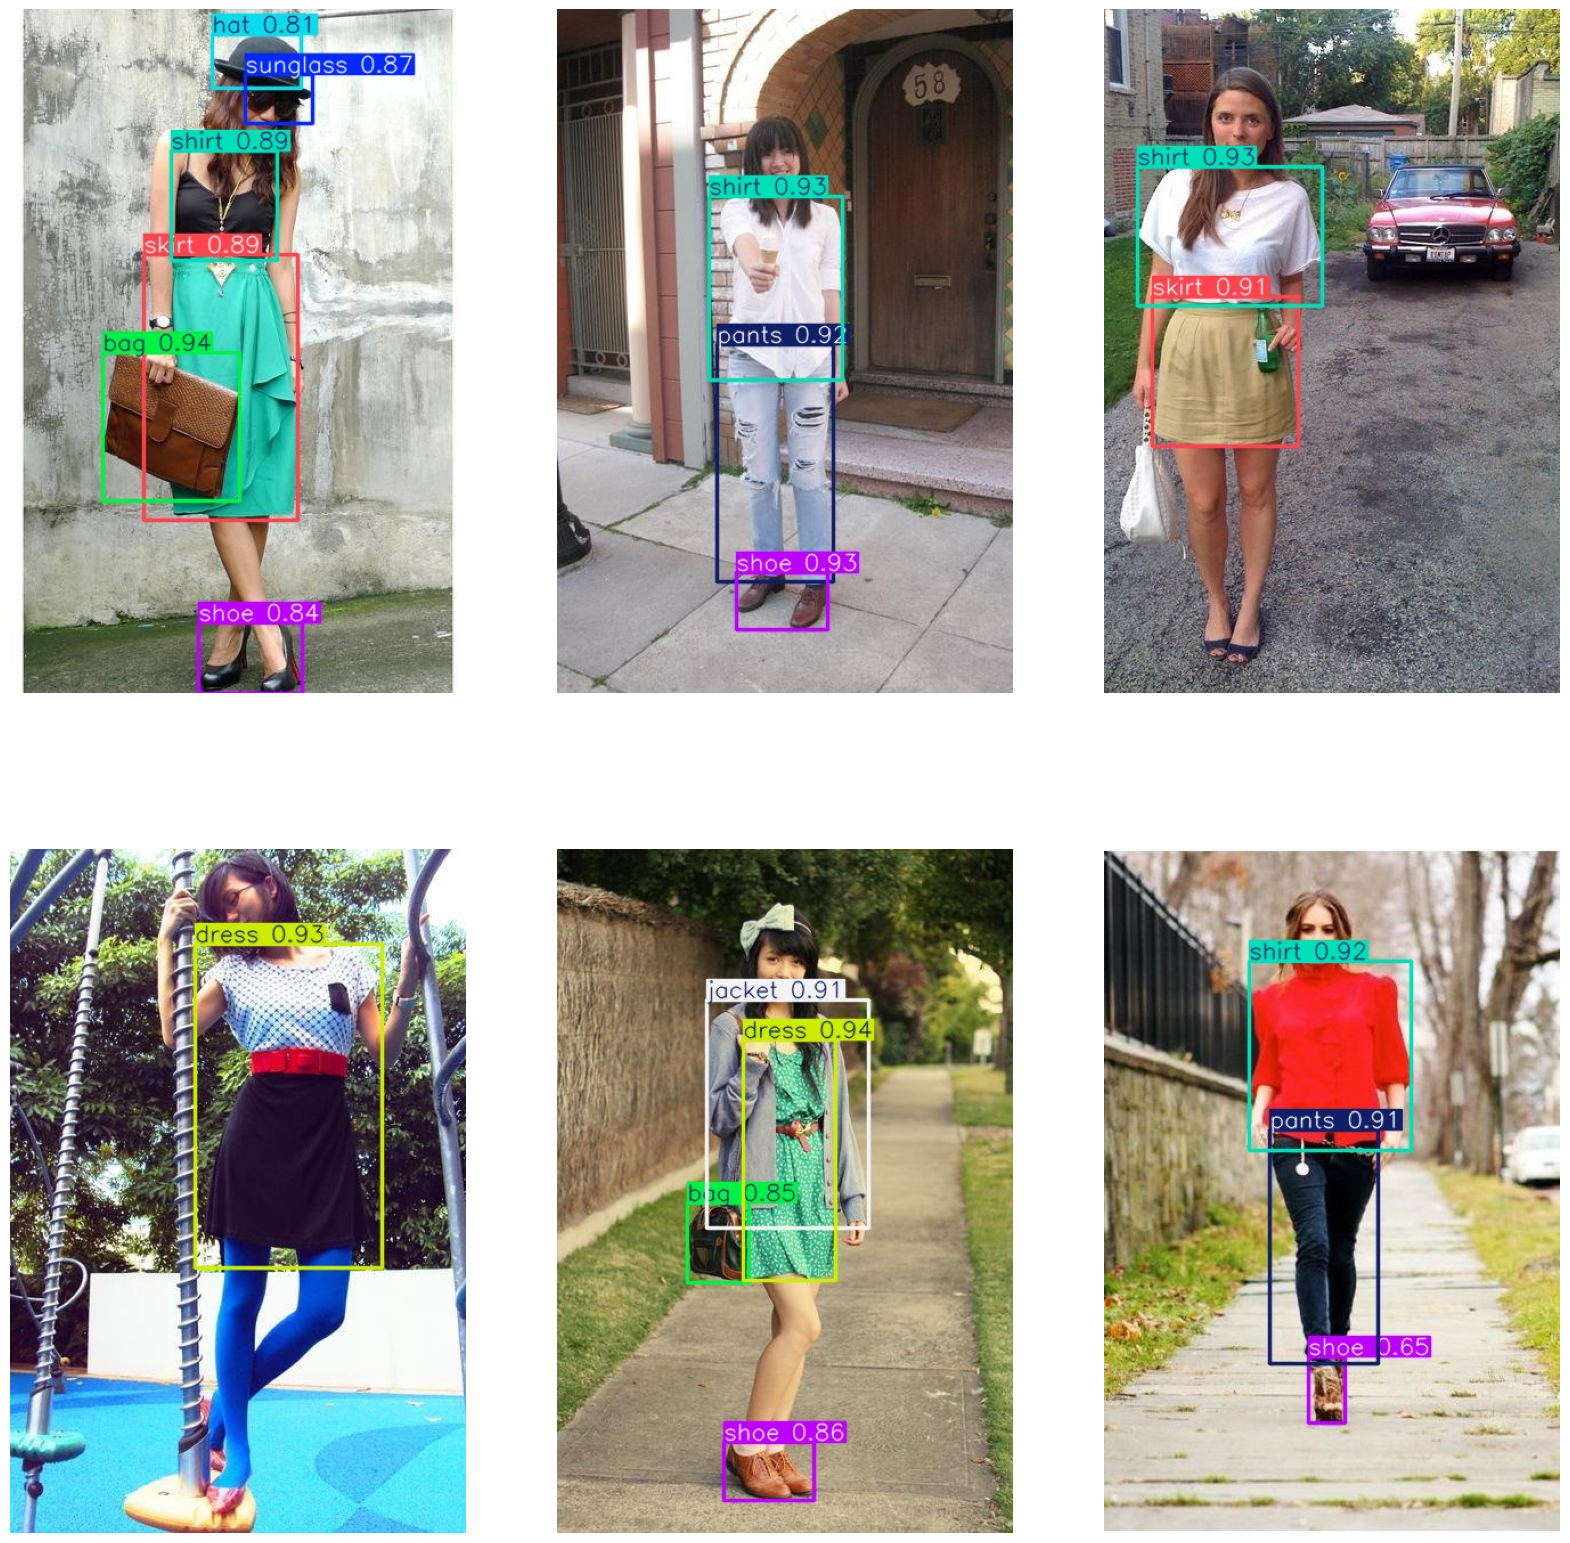

In [20]:
plt.figure(figsize=(20, 20))
imgs = random.sample(os.listdir(images_path), 6)

for idx, img in enumerate(imgs, start=1):
    save_name = f"predict_{idx}"
    save_path = os.path.join("/kaggle/working/runs/detect", save_name)

    # Run prediction
    model.predict(
        source=os.path.join(images_path, img),
        conf=0.4,
        save=True,
        line_width=2,
        project="/kaggle/working/runs/detect",
        name=save_name
    )

    # Load and display saved image
    try:
        saved_files = os.listdir(save_path)
        result_img = [f for f in saved_files if f.endswith(".jpg") or f.endswith(".png")]
        if not result_img:
            print(f"No image found in {save_path}")
            continue

        im = plt.imread(os.path.join(save_path, result_img[0]))
        plt.subplot(2, 3, idx)
        plt.axis("off")
        plt.imshow(im)

    except FileNotFoundError:
        print(f"Folder not found: {save_path}")
